This notebook walks through the process of modelling and fitting TESS cleaned lightcurves with harmonics to extract the phase curve from a planet's atmospheric brightness modulation.

**Prerequisite:** the data explored in this notebook must be lightcurves cleaned for phase curve analysis, i.e.
- Bad quality flag data have been removed
- Transits and secondary eclipses have been removed
- Data taken around momentum dumps have been removed
- Unexpected flux ramps have been removed
These clean lightcurves are produced in the TESSPhaseCurve_KELT-9b_DataCleaning.ipynb notebook.

# Background

In this notebook, you will investigate the atmospheres of ultra-hot giant exoplanets by modelling the light they emit and reflect over the course of their orbits around their host stars. This light coming from planets over their entire orbital period is referred to as a phase curve. Such data can provide key insights on the heat distribution, wind circulation, and the potential presence/composition of clouds in the atmospheres of these extremely hot (>2000 K) gas giants orbiting very close (orbital periods less than 10 days) to their stars. 

Hot Jupiters (HJs) are a class of gas giant planets that are similar in mass to Jupiter in our Solar System, but orbit very close to their stars (P < 10 days, a ~ 0.01-0.1 AU). Due to their proximity to their host stars, these planets are expected to be **tidally locked**, meaning that one side of the planet always faces towards the star while the other side always faces away (much like how we only see one face of the Moon). Consequently, HJs have permanent daysides (the side facing the star) that are blasted with intense stellar irradiation and are thus much hotter than their permanent nightsides (the side facing away from the star). For transiting HJs, i.e. HJs that pass in front of their star from our perspective here on Earth, we can observe this temperature gradient across the planet by measuring the light it emits and reflects over the course of its orbit around its host star, i.e. the **planet's phase curve**. The hotter dayside gives off more light than the nightside, due to the dayside's higher thermal blackbody radiation as well as the starlight that reflects off the dayside atmosphere. In contrast, the nightside is much cooler, so it does not give off as much thermal blackbody radiation and it does not receive any starlight that can reflect off the nightside atmosphere. The following graphic shows how the light we receive from the planet changes over the course of its orbit and how that impacts the shape of the lightcurve.

<div>
<img src="notebook_images/JWST_PhaseCurveGeometry.png" width="1000"/>
</div> 

As seen in the above graphic, we receive **more light from the planet before/after secondary eclipse (when the planet passes behind its host star** because that is when the dayside of the planet is facing us the observer. Conversely, we receive **less light from the planet before/after transit (when the planet passes in front of its host star)** because that is when the nightside of the planet is facing us. Furthermore, this variability of light measured from the planet modulates with a periodicity that matches the orbital period of the planet.

In <a href="https://arxiv.org/abs/1711.07696">Parmentier and Crossfield 2017</a>, you learned that atmospheric dynamics can affect the shape of the planet's phase curve. The strong temperature contrast between the planet's day and nightsides can drive **superrotating equatorial jets** that circulate around the planet to redistribute heat from the hot dayside to the cooler nightside. This can drive the hotspot (hottest point on the planet) to be offset longitudinally from the substellar point (the longitude that is closest to the star). As a result, the peak of the planet's phase curve will be offset from the midpoint of the secondary eclipse. Typically, this offset is eastward from the substellar point so the peak will appear before the midpoint of the secondary eclipse as shown in Figure 1 of <a href="https://arxiv.org/abs/1711.07696">Parmentier and Crossfield 2017</a> (reproduced below):

<div>
<img src="notebook_images/Parmentier_2017_PhaseCurveParameters.JPG" width="700"/>
</div>

This figure also shows how the planet's phase curve can be modelled with a **sinusoid parameterized by its period, amplitude, and offset**. Specifically, the phase curve contributes a cosine component to the lightcurve, since it is at a miniumum at phase = 0. As previously established, the period should match the orbital period of the planet. The amplitude tells us something about the temperature gradient and atmosphere's reflective properties across the planet. The offset tells us something about the equatorial jet velocity.

In reality, this atmospheric brightness modulation from the planet is not the only astrophysical effect we see in the lightcurve. In <a href="https://iopscience.iop.org/article/10.1088/1538-3873/aa7112/meta">Shporer 2017</a>, you read about two other harmonics in the lightcurve driven by stellar effects, ellipsoidal variations and Doppler beaming. **Ellipsoidal variations** arise from the elongated teardrop (ellipsoidal rather than spherical) shape of the star due to the distortion caused by the planet's close proximity and thus non-negligible gravitational effect raising tides on the star. We can see this visualized in the following figure (Figure 2 of <a href="https://ui.adsabs.harvard.edu/abs/2012ApJ...751..112J/abstract">Jackson et al. 2012</a>):

<div>
<img src="notebook_images/Jackson_2012_EllipsoidalVariations.png" width="700"/>
</div>

*(I know the tickmarks for the phase along the x-axis don't really make sense but unfortunately this was the best image I could find, just trust me with the phase values I added in.)* 

The star is elongated along the axis between the planet and the star. Thus we see a small cross-section of the star during transit and secondary eclipse (phases 0, 0.5, and 1) that corresponds to less flux from the star. In contrast, during quadratures (phases 0.25 and 0.75), we see an elongated cross section of the star and thus more flux from the star. In this way, ellipsoidal variations contribute a cosine component (since it is at a minimum during phase = 0) with twice the frequency of the planet's orbit.

**Doppler beaming** is related to the radial velocity of the star. As the star moves towards us, its light gets amplified by the relativistic Doppler effect; conversely as it moves away, it appears to get dimmer because of the relativistic Doppler effect. By conservation of momentum, the star is moving towards us fastest and thus appears brightest at phase = 0.25 (when the planet is moving away from us fastest); the star is moving away from us fastest and thus appears dimmest at phase = 0.75 (when the planet is moving towards us fastest). Doppler beaming contributes a sine component (since it is at 0 during phase = 0 when the star's orbit contributes no additional radial velocity towards/away from us on top of the overall systemic velocity) with a periodicity that matches the orbital period of the planet. These three effects are visualized in Figure 1 of <a href="https://iopscience.iop.org/article/10.1088/1538-3873/aa7112/meta">Shporer 2017</a>.

<div>
<img src="notebook_images/Shporer_2017_LightcurveComponents.JPG" width="700"/>
</div>

The green curve on the bottom is the planet's phase curve (atmospheric brightness modulation), a cosine with $P = P_{\mathrm{orbit}}$. The middle blue curve represents ellipsoidal variations, a cosine with $P = \frac{P_{\mathrm{orbit}}}{2}$. The top red curve represents Doppler beaming, a sine with $P = P_{\mathrm{orbit}}$. Note that the amplitudes are not to scale.

For your project, you will follow the methodology of <a href="https://ui.adsabs.harvard.edu/abs/2020AJ....160...88W/abstract">Wong et al. 2020</a> to simultaneously model the different harmonics of TESS lightcurves of systems with transiting ultra-hot Jupiters and recover the parameters that describe the phase curve of the planet's atmospheric brightness modulation. This will provide key insight on the thermal distribution and potentially the cloud properties of these extremely irradiated gas giant atmospheres.



# Imports

You will need to have the following packages installed:
- numpy: https://numpy.org/install/
- matplotlib: https://matplotlib.org/stable/users/installing/index.html
- pandas: https://pandas.pydata.org/docs/getting_started/install.html
- astropy: https://docs.astropy.org/en/stable/install.html
- lightkurve: https://docs.lightkurve.org/about/install.html

In [1]:
# General data manipulation and plotting packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u

# Exoplanet data packages
import lightkurve as lk

# Library of custom functions
import TESSPhaseCurve_lib as TPC

# The following are my preferred matplotlib settings; I use a custom font that I have saved locally on my system.
# You can adjust the lines below to suit your preferences, or just comment them out entirely.
from matplotlib import font_manager
font_dir = ['/home/paiasnodkar.1/fonts'] # This will not work for you since it is a local directory on my system
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)

fontweight = 300
plt.rcParams['font.family'] = 'monospace'
plt.rcParams['font.monospace'] = ['Mulish']
plt.rcParams["font.weight"] = fontweight
plt.rcParams['axes.labelweight'] = 1.3*fontweight
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['axes.titlesize'] = 22

# Explore the lightcurve model

We will adopt the analytic model presented in Section 2 of <a href="https://ui.adsabs.harvard.edu/abs/2020AJ....160...88W/abstract">Wong et al. 2020</a> to fit the cleaned TESS lightcurves. Equation 7 represents the full lightcurve model:

$\psi_{\mathrm{tot}}(t) = \frac{\psi_{\star}(t) \Theta(t) + \lambda_{\mathrm{e}}(t)\psi_{\mathrm{p}}(t)}{1 + \bar{f_{\mathrm{p}}}}$

Here I've labelled the $\psi_{\mathrm{tot}}(t)$ instead of $\psi'(t)$ to make it clear that this represents the full lightcurve with both the planet phase curve and stellar variation effects. Let's inspect each component of this individually. 

### Planet phase curve

The planet's atmospheric brightness modulation is described by Equation 1 in <a href="https://ui.adsabs.harvard.edu/abs/2020AJ....160...88W/abstract">Wong et al. 2020</a>:

$\psi_{\mathrm{p}}(t) = \bar{f_{\mathrm{p}}} + B_1 \cos{(2 \pi \phi + \delta)}$,

where $\phi = \frac{t - t_0}{P}$. Let's visualize this over 1 orbital period. Fill in the parameters with the values from 
<a href="https://ui.adsabs.harvard.edu/abs/2020AJ....160...88W/abstract">Wong et al. 2020</a> before running the cell below. Don't forget to convert the mid-transit time to BTJD.

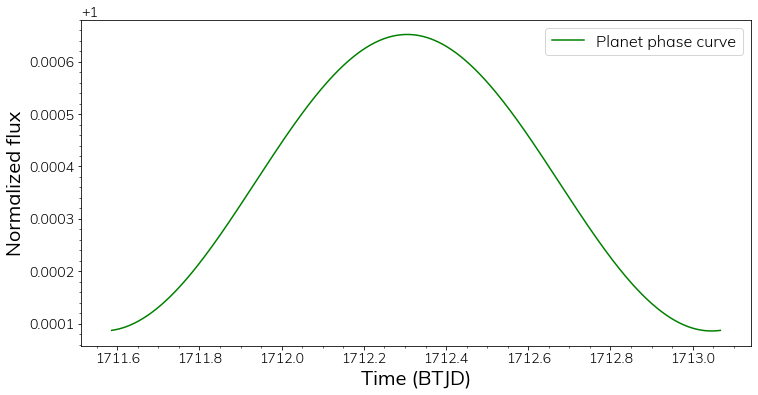

In [2]:
# Fill in the parameters below, e.g. with values from Wong et al. 2020
t_0, P = (2458711.58627 - 2457000.0)*u.day, 1.4811235*u.day
fp, B1, delta = 369e-6, -283.0e-6, 5.2*np.pi/180.

# Make an array of times that spans 1 orbital period
time = np.linspace(t_0, t_0+1*P, 1000)

# Make planet phase curve model using relevant function from custom library (TESSPhaseCurve_lib.py)
flux_planet = TPC.psi_p(time.value, t_0.value, P.value, fp, B1, delta) + 1. # Add 1 to normalize baseline around 1 for comparison with other components

# Plot the model
plt.figure(figsize=(12,6))
plt.plot(time, flux_planet, color='g', label='Planet phase curve')
plt.xlabel('Time (BTJD)')
plt.ylabel('Normalized flux')
plt.legend(fontsize=16)
plt.show()

Note that $\lambda_e(t)$ represents a model of the dip in brightness from secondary eclipse (the loss of flux from the star-planet system when the planet passes behind the star). Since we removed secondary eclipses from our data, we can set $\lambda_e(t) = 1$

### Stellar harmonics
The stellar harmonics are described by Equation 2 in <a href="https://ui.adsabs.harvard.edu/abs/2020AJ....160...88W/abstract">Wong et al. 2020</a>:

$\psi_{\star}(t) = 1 + \Sigma_{k=1}^{n} A_k \sin{2 \pi k \phi}+ \Sigma_{k=2}^n B_k \cos{2 \pi k \phi}$

We will only go up to the first 3 harmonics, so this reduces to:

$\psi_{\star}(t) = 1 + A_1 \sin{2 \pi \phi} + A_2 \sin{4 \pi \phi} + B_2 \cos{4 \pi \phi} +
A_3 \sin{6 \pi \phi} +  B_3 \cos{6 \pi \phi}$

The $A_1$ component corresponds to the Doppler beaming signal while the $B_2$ component corresponds to ellipsoidal variations. Let's visualize this over one orbital period.

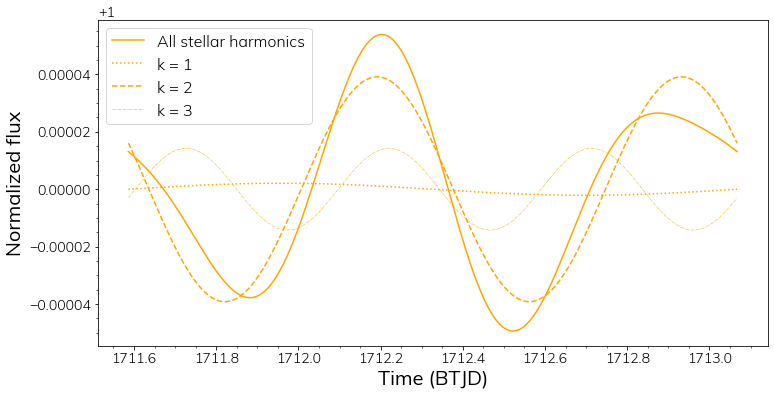

In [3]:
# Fill in the parameters below, e.g. with values from Wong et al. 2020
A1, A2, B2, A3, B3 = 2.1e-6, -35.7e-6, 16.1e-6, 13.9e-6, -3.0e-6

# Make stellar harmonics model using relevant function from custom library
flux_k1 = TPC.psi_star_1(time.value, t_0.value, P.value, A1) + 1. # k = 1
flux_k2 = TPC.psi_star_2(time.value, t_0.value, P.value, A2, B2) + 1. # k = 1
flux_k3 = TPC.psi_star_3(time.value, t_0.value, P.value, A3, B3) + 1. # k = 1
flux_star = TPC.psi_star_sum(time.value, t_0.value, P.value, A1, A2, B2, A3, B3) # all harmonics

# Plot the model
plt.figure(figsize=(12,6))
plt.plot(time, flux_star, color='orange', label='All stellar harmonics')
plt.plot(time, flux_k1, color='orange', linestyle='dotted', label='k = 1')
plt.plot(time, flux_k2, color='orange', linestyle='dashed', label='k = 2')
plt.plot(time, flux_k3, color='orange', linestyle='dashdot', linewidth=0.5, label='k = 3')
plt.xlabel('Time (BTJD)')
plt.ylabel('Normalized flux')
plt.legend(fontsize=16)
plt.show()

### Stellar pulsations
The stellar pulsations are described by Equation 6 in <a href="https://ui.adsabs.harvard.edu/abs/2020AJ....160...88W/abstract">Wong et al. 2020</a>:

$\Theta(t) = 1 + \alpha \sin{2 \pi \xi} + \beta \cos{2 \pi \xi}$

where $\xi = \frac{t-t_0}{\Pi}$. Let's visualize this over 1 orbital period. Make sure to use consistent units

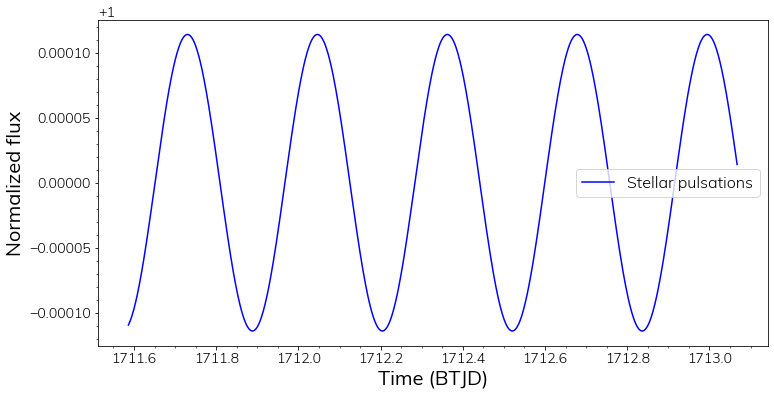

In [4]:
# Fill in the parameters below, e.g. with values from Wong et al. 2020
Pi = (7.58695 * 1/24.)*u.day
alpha, beta = 31.9e-6, -109.5e-6

# Make stellar harmonics model using relevant function from custom library
flux_pulse = TPC.Theta(time.value, t_0.value, Pi.value, alpha, beta)

# Plot the model
plt.figure(figsize=(12,6))
plt.plot(time, flux_pulse, color='b', label='Stellar pulsations')
plt.xlabel('Time (BTJD)')
plt.ylabel('Normalized flux')
plt.legend(fontsize=16)
plt.show()

### Combined lightcurve

Let's visualize the combined lightcurve with all the different components.

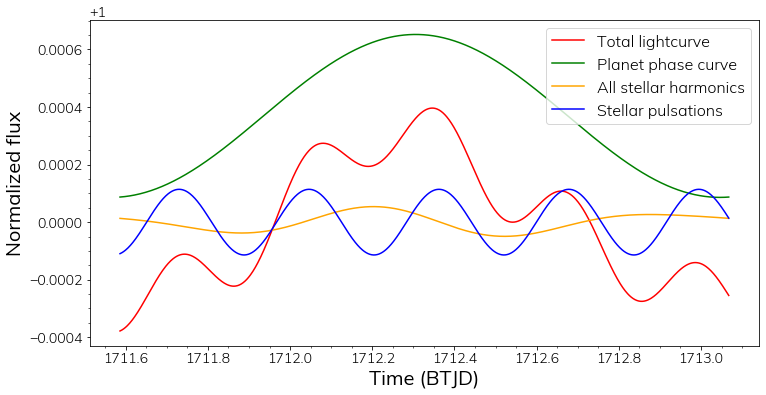

In [5]:
# Combined model
flux_model = TPC.psi_tot(time.value, t_0.value, P.value, Pi.value, alpha, beta, fp, delta,
                         A1, B1, A2, B2, A3, B3)

# Plot the model
plt.figure(figsize=(12,6))
plt.plot(time, flux_model, color='r', label='Total lightcurve')
plt.plot(time, flux_planet, color='g', label='Planet phase curve')
plt.plot(time, flux_star, color='orange', label='All stellar harmonics')
plt.plot(time, flux_pulse, color='b', label='Stellar pulsations')
plt.xlabel('Time (BTJD)')
plt.ylabel('Normalized flux')
plt.legend(fontsize=16)
plt.show()

Take some time to try out different parameter values and extending the lightcurve to more orbital periods to see how this affects the shape of the lightcurve. Think about why some components lightcurves are centered around 1 while others are not.

# Read in data

Let's use pandas to read in the data.

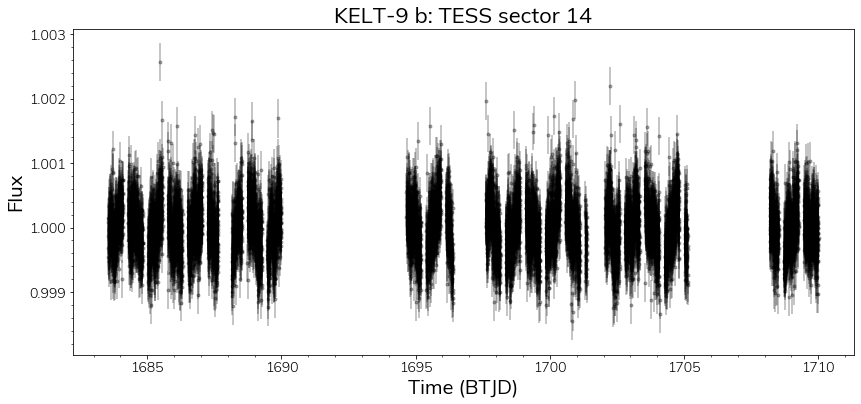

In [6]:
planet_name = 'KELT-9 b'
df = pd.read_csv('lightcurves/'+planet_name.replace(" ", "")+'.csv')
sectors = np.unique(df.sector)
sector_ind = 0 # set between 0 and len(sectors) to select an individual sector, set to 'all' for all sectors

if sector_ind == 'all':
    sector = 'all'
    time = np.array(df.time)
    flux = np.array(df.flux)
    flux_err = np.array(df.flux_err)
else:
    sector = sectors[sector_ind]
    sector_bool = df.sector == sector
    time = np.array(df.time)[sector_bool]
    flux = np.array(df.flux)[sector_bool]
    flux_err = np.array(df.flux_err)[sector_bool]        

# Plot lightcurve
plt.figure(figsize=(14,6))
plt.errorbar(time, flux, flux_err, fmt='.', color='k', alpha=0.3)
plt.xlabel('Time (BTJD)')
plt.ylabel('Flux')
plt.title(planet_name+': TESS sector '+str(sector))
plt.show()

Let us calculate the individual model components over the times at which the data were taken and overlay them on the data.

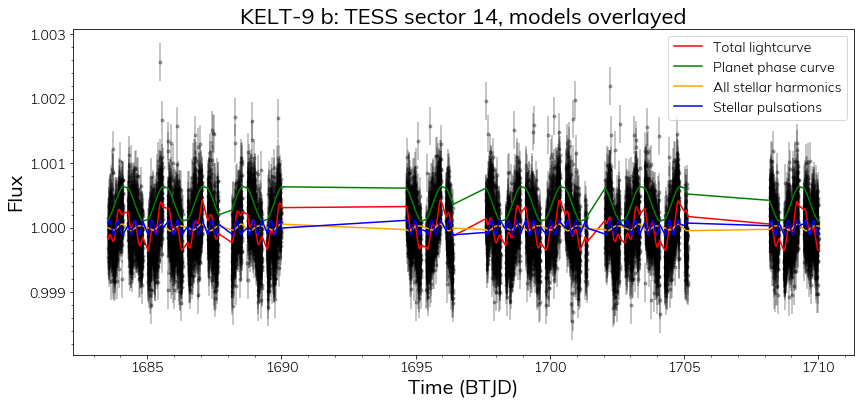

In [7]:
# Combined model
flux_model = TPC.psi_tot(time, t_0.value, P.value, Pi.value, alpha, beta, fp, delta,
                         A1, B1, A2, B2, A3, B3)

# Planet phase curve
flux_model_planet = TPC.psi_p(time, t_0.value, P.value, fp, B1, delta)

# Stellar harmonics
flux_model_star = TPC.psi_star_sum(time, t_0.value, P.value, A1, A2, B2, A3, B3)

# Stellar pulsations
flux_model_pulse = TPC.Theta(time, t_0.value, Pi.value, alpha, beta)

# Plot lightcurve with models
plt.figure(figsize=(14,6))
plt.errorbar(time, flux, flux_err, fmt='.', color='k', alpha=0.3, zorder=0)
plt.plot(time, flux_model, color='r', label='Total lightcurve', zorder=1)
plt.plot(time, flux_model_planet+1, color='g', label='Planet phase curve', zorder=1)
plt.plot(time, flux_model_star, color='orange', label='All stellar harmonics', zorder=1)
plt.plot(time, flux_model_pulse, color='b', label='Stellar pulsations', zorder=1)
plt.xlabel('Time (BTJD)')
plt.ylabel('Flux')
plt.legend(fontsize=14)
plt.title(planet_name+': TESS sector '+str(sector)+', models overlayed')
plt.show()

There are a lot of data points spanning a broad range of times, so it is difficult to see how well the models match the data. For ease of visualization, let's "phase-fold" the data over the orbital period of the planet such that all data taken when the planet is at a given fixed point in its orbit are mapped to the same phase ($\phi$). We will define our phases according to the convention that phase ranges from $\phi = [0, 1]$, where $\phi = 0$ and $\phi = 1$ correspond to mid-transit while $\phi = 0.5$ corresponds to secondary eclipse. Lightcurve manipulation is easier with the <a href="https://docs.lightkurve.org/">*lightkurve*</a> package.

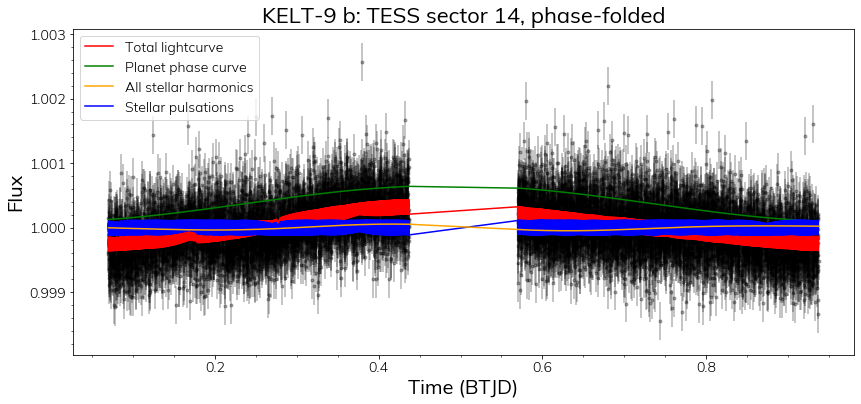

In [8]:
# Create a Lightkurve object for the data
lc_data = {'time': time*u.day,
           'flux': flux,
           'flux_err': flux_err}
lc_data = lk.LightCurve(lc_data)

# Use the custom function to fold the lightcurve
lc_fold = TPC.fold_lk(lc_data, P, t_0)

### Repeat for the models ###

# Combined model
lc_model = {'time': time*u.day,
           'flux': flux_model}
lc_model = lk.LightCurve(lc_model)
lc_fold_model = TPC.fold_lk(lc_model, P, t_0)

# Planet phase curve
lc_model_planet = {'time': time*u.day,
           'flux': flux_model_planet}
lc_model_planet = lk.LightCurve(lc_model_planet)
lc_fold_model_planet = TPC.fold_lk(lc_model_planet, P, t_0)

# Stellar harmonics
lc_model_star = {'time': time*u.day,
           'flux': flux_model_star}
lc_model_star = lk.LightCurve(lc_model_star)
lc_fold_model_star = TPC.fold_lk(lc_model_star, P, t_0)

# Stellar pulsations
lc_model_pulse = {'time': time*u.day,
           'flux': flux_model_pulse}
lc_model_pulse = lk.LightCurve(lc_model_pulse)
lc_fold_model_pulse = TPC.fold_lk(lc_model_pulse, P, t_0)

# Plot folded lightcurve with models
plt.figure(figsize=(14,6))
plt.errorbar(lc_fold.time.value, lc_fold.flux.value, lc_fold.flux_err.value, fmt='.', color='k', alpha=0.3, zorder=0)
plt.plot(lc_fold_model.time.value, lc_fold_model.flux.value, color='r', label='Total lightcurve', zorder=1)
plt.plot(lc_fold_model_planet.time.value, lc_fold_model_planet.flux.value+1, color='g', label='Planet phase curve', zorder=1)
plt.plot(lc_fold_model_star.time.value, lc_fold_model_star.flux.value, color='orange', label='All stellar harmonics', zorder=2)
plt.plot(lc_fold_model_pulse.time.value, lc_fold_model_pulse.flux.value, color='b', label='Stellar pulsations', zorder=1)
plt.xlabel('Time (BTJD)')
plt.ylabel('Flux')
plt.legend(fontsize=14)
plt.title(planet_name+': TESS sector '+str(sector)+', phase-folded')
plt.show()

We can also bin the data, i.e. median combine data points near each other, to reduce the scatter and see how well the stellar harmonics/pulsation models capture of some of the substructure in the phase curve.

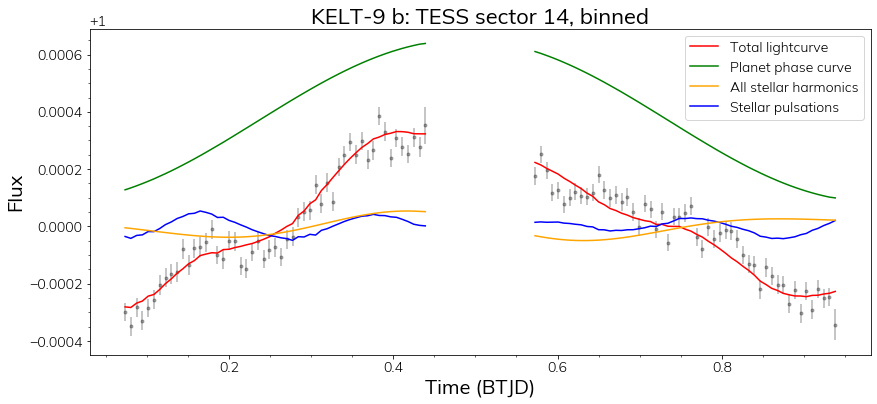

In [9]:
bin_width = (15*u.min).to(u.day)/P # fraction of orbital period to convert to phase

# Bin data
lc_bin = lc_fold.bin(bin_width * u.day) # as a hack, need to provide unit of days for binning with Lightkurve

# Bin models
lc_bin_model = lc_fold_model.bin(bin_width * u.day)
lc_bin_model_planet = lc_fold_model_planet.bin(bin_width * u.day)
lc_bin_model_star = lc_fold_model_star.bin(bin_width * u.day)
lc_bin_model_pulse = lc_fold_model_pulse.bin(bin_width * u.day)

# Plot binned lightcurve with models
plt.figure(figsize=(14,6))
plt.errorbar(lc_bin.time.value, lc_bin.flux.value, lc_bin.flux_err.value, fmt='.', color='k', alpha=0.3, zorder=0)
plt.plot(lc_bin_model.time.value, lc_bin_model.flux.value, color='r', label='Total lightcurve', zorder=1)
plt.plot(lc_bin_model_planet.time.value, lc_bin_model_planet.flux.value+1, color='g', label='Planet phase curve', zorder=1)
plt.plot(lc_bin_model_star.time.value, lc_bin_model_star.flux.value, color='orange', label='All stellar harmonics', zorder=2)
plt.plot(lc_bin_model_pulse.time.value, lc_bin_model_pulse.flux.value, color='b', label='Stellar pulsations', zorder=1)
plt.xlabel('Time (BTJD)')
plt.ylabel('Flux')
plt.legend(fontsize=14)
plt.title(planet_name+': TESS sector '+str(sector)+', binned')
plt.show()

Visually, it looks like the <a href="https://ui.adsabs.harvard.edu/abs/2020AJ....160...88W/abstract">Wong et al. 2020</a> are a decent match to the Sector 14 data. We will introduce model fitting in another notebook to quantitatively determine the best-fit model parameters.

For a final visualization to build intuition, let's extract the different components from the data. The following cell shows how to use the functions from the custom library to isolate the planet phase curve, stellar harmonics, and stellar pulsations.

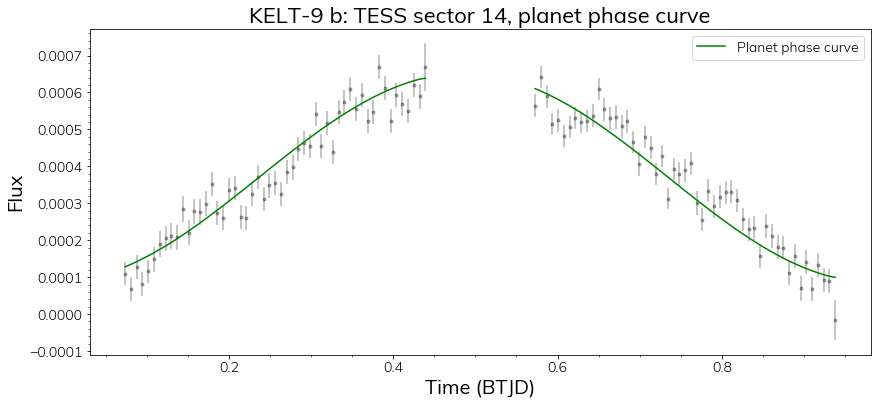

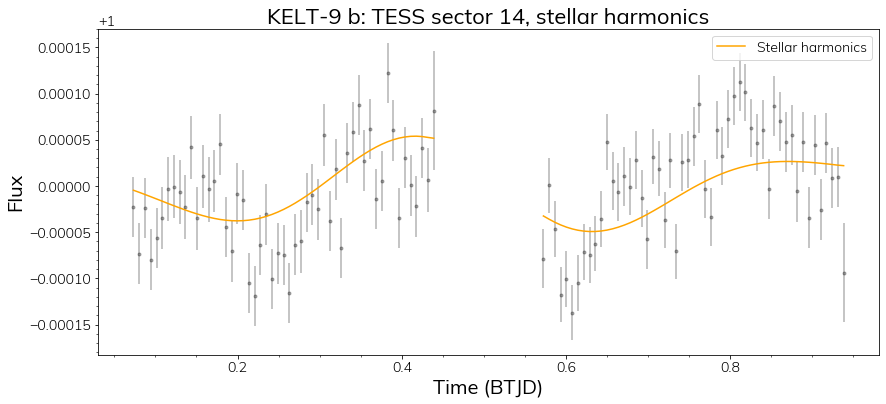

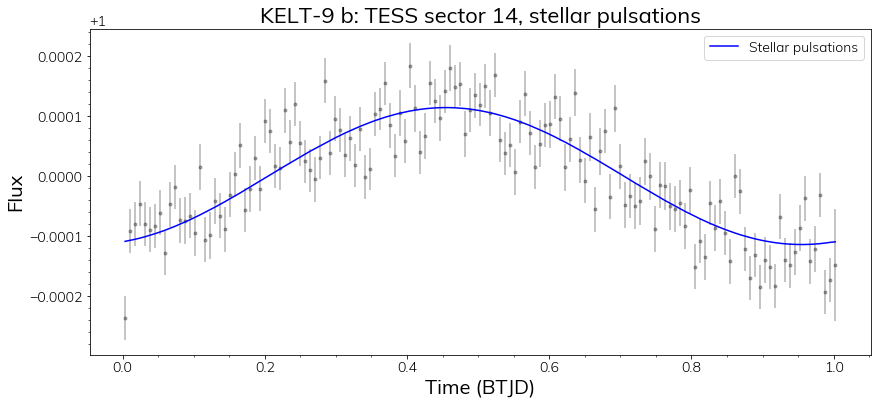

In [10]:
# Extract planet phase curve
lc_planet = TPC.lc_transform_planet(lc_data, t_0.value, P.value, Pi.value, alpha, beta, fp, A1, A2, B2, A3, B3)
lc_fold_planet = TPC.fold_lk(lc_planet, P, t_0)
lc_bin_planet = lc_fold_planet.bin(bin_width * u.day)

# Plot planet phase curve with model
plt.figure(figsize=(14,6))
plt.errorbar(lc_bin_planet.time.value, lc_bin_planet.flux.value, lc_bin_planet.flux_err.value, fmt='.', color='k', alpha=0.3, zorder=0)
plt.plot(lc_bin_model_planet.time.value, lc_bin_model_planet.flux.value, color='g', label='Planet phase curve', zorder=1)
plt.xlabel('Time (BTJD)')
plt.ylabel('Flux')
plt.legend(fontsize=14)
plt.title(planet_name+': TESS sector '+str(sector)+', planet phase curve')
plt.show()

# Extract stellar harmonics
lc_star = TPC.lc_transform_star(lc_data, t_0.value, P.value, Pi.value, alpha, beta, fp, B1, delta)
lc_fold_star = TPC.fold_lk(lc_star, P, t_0)
lc_bin_star = lc_fold_star.bin(bin_width * u.day)

# Plot stellar harmonics with model
plt.figure(figsize=(14,6))
plt.errorbar(lc_bin_star.time.value, lc_bin_star.flux.value, lc_bin_star.flux_err.value, fmt='.', color='k', alpha=0.3, zorder=0)
plt.plot(lc_bin_model_star.time.value, lc_bin_model_star.flux.value, color='orange', label='Stellar harmonics', zorder=1)
plt.xlabel('Time (BTJD)')
plt.ylabel('Flux')
plt.legend(fontsize=14)
plt.title(planet_name+': TESS sector '+str(sector)+', stellar harmonics')
plt.show()

# Extract stellar pulsations
lc_pulse = TPC.lc_transform_pulse(lc_data, t_0.value, P.value, fp, delta, A1, A2, B1, B2, A3, B3)
lc_fold_pulse = TPC.fold_lk(lc_pulse, Pi, t_0) # Fold over Pi instead of P for period of pulsations
lc_fold_pulse = lc_fold_pulse.bin(bin_width * u.day)
# Fold pulsation model over Pi as well, rebin
lc_fold_model_pulse = TPC.fold_lk(lc_model_pulse, Pi, t_0)
lc_bin_model_pulse = lc_fold_model_pulse.bin(bin_width * u.day)

# Plot stellar pulsations with model
plt.figure(figsize=(14,6))
plt.errorbar(lc_fold_pulse.time.value, lc_fold_pulse.flux.value, lc_fold_pulse.flux_err.value, fmt='.', color='k', alpha=0.3, zorder=0)
plt.plot(lc_bin_model_pulse.time.value, lc_bin_model_pulse.flux.value, color='b', label='Stellar pulsations', zorder=1)
plt.xlabel('Time (BTJD)')
plt.ylabel('Flux')
plt.legend(fontsize=14)
plt.title(planet_name+': TESS sector '+str(sector)+', stellar pulsations')
plt.show()

To check your understanding, try to match these to figures in <a href="https://ui.adsabs.harvard.edu/abs/2020AJ....160...88W/abstract">Wong et al. 2020</a> (not all are exactly the same, but similar in concept). Go through this process with different parameters and sectors of data to build familiarity with the data and models.